## Table of Contents
<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)  
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means Clustering](#Part-4:-K-means-Clustering)  
</ul>

## Part 1: Load Data

In [37]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [38]:
# import three lists: titles and wikipedia synopses
titles = open('./data/title_list.txt').read().split('\n')
titles = titles[:100] # ensures that only the first 100 are read in

# the wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE".
# each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

# combine imdb and wiki to get full synoposes for the top 100 movies.
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

# because these synopses have already been ordered in popularity order,
# we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

## Part 2: Tokenizing and Stemming 

Load stopwords and stemmer function from NLTK library. Stop words are liek "a", "the", or "in" which don't convey significant meaning.
<br/>
<b>Stemming</b> is the process of breaking a word down into its root.

In [39]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words("english")

print("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print(stopwords[:10])

We use 179 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [40]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    """
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word not in stopword:
                tokens.append(word)
    """
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

# tokenization without stemming
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [41]:
# for example
print(tokenization_and_stemming("she looked at her father's arm."))
print(tokenization("she looked at her father's arm."))

[u'look', u'father', "'s", u'arm']
['looked', 'father', "'s", 'arm']


Use our defined functions to analyze (i.e. tokenize, stem) our synoposes. 

In [42]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation. 

In [43]:
vocab_frame_dict = {docs_stemmed[i] : docs_tokenized[i] for i in range(len(docs_stemmed))}
print(vocab_frame_dict['angel'])

angeles


## Part 3: TF-IDF 

In [44]:
# define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, stop_words='english', use_idf=True,
                             tokenizer=tokenization_and_stemming, ngram_range=(1,1))
tfidf_matrix = tfidf_model.fit_transform(synopses) # fit the vectorizer to synopses

print("In total, there are " + str(tfidf_matrix.shape[0]) + \
     " synopses and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synopses and 538 terms.


In [45]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF. 

In [46]:
tf_selected_words = tfidf_model.get_feature_names()
tf_selected_words

[u"'d",
 u'abandon',
 u'abl',
 u'accept',
 u'accid',
 u'accompani',
 u'accus',
 u'act',
 u'action',
 u'actual',
 u'admit',
 u'afterward',
 u'ago',
 u'agre',
 u'air',
 u'aliv',
 u'allow',
 u'alon',
 u'alreadi',
 u'alway',
 u'american',
 u'angri',
 u'angrili',
 u'announc',
 u'anoth',
 u'answer',
 u'anyon',
 u'anyth',
 u'apart',
 u'appar',
 u'appear',
 u'approach',
 u'area',
 u'argu',
 u'arm',
 u'armi',
 u'arrang',
 u'arrest',
 u'arriv',
 u'ask',
 u'assign',
 u'assist',
 u'assum',
 u'attack',
 u'attempt',
 u'attend',
 u'attent',
 u'attract',
 u'audienc',
 u'avoid',
 u'away',
 u'bad',
 u'bar',
 u'bare',
 u'battl',
 u'beat',
 u'becom',
 u'bed',
 u'beg',
 u'believ',
 u'best',
 u'better',
 u'big',
 u'black',
 u'blow',
 u'board',
 u'bodi',
 u'book',
 u'boss',
 u'boy',
 u'break',
 u'brief',
 u'bring',
 u'broken',
 u'brother',
 u'build',
 u'burn',
 u'busi',
 u'buy',
 u'ca',
 u'camp',
 u'captain',
 u'captur',
 u'car',
 u'care',
 u'career',
 u'carri',
 u'case',
 u'catch',
 u'caus',
 u'chanc',
 u'c

### Calculate Document Similarity 

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print(cos_matrix)

[[ 1.          0.1996283   0.23342595 ...,  0.3581728   0.3277855
   0.17714484]
 [ 0.1996283   1.          0.26626879 ...,  0.26910321  0.22856581
   0.10870124]
 [ 0.23342595  0.26626879  1.         ...,  0.27738654  0.24669308
   0.12805055]
 ..., 
 [ 0.3581728   0.26910321  0.27738654 ...,  1.          0.55040973
   0.08151334]
 [ 0.3277855   0.22856581  0.24669308 ...,  0.55040973  1.          0.13005234]
 [ 0.17714484  0.10870124  0.12805055 ...,  0.08151334  0.13005234  1.        ]]


## Part 4: K-means Clustering 

In [48]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

### 4.1 Analyze K-means Result 

In [49]:
# create DataFrame films from all of the input files.
films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index=[clusters], columns=['rank', 'title', 'cluster'])

In [50]:
frame.head(10)

,rank,title,cluster
2,0,The Godfather,2
2,1,The Shawshank Redemption,2
4,2,Schindler's List,4
4,3,Raging Bull,4
4,4,Casablanca,4
0,5,One Flew Over the Cuckoo's Nest,0
4,6,Gone with the Wind,4
1,7,Citizen Kane,1
0,8,The Wizard of Oz,0
2,9,Titanic,2


In [51]:
print("Number of films included in each cluster: ")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster: 


,cluster
4,30
2,30
1,18
0,16
3,6


In [52]:
grouped = frame['rank'].groupby(frame['cluster'])
print("Average rank (1 to 100) per cluster:")
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,53.687500
1,53.888889
2,49.933333
3,52.833333
4,43.533333


In [53]:
print "<Document clustering result by K-means>"

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print("Cluster " + str(i) + " words:")
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ",",

    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ") 
    print(", ".join(cluster_movies))

<Document clustering result by K-means>
Cluster 0 words:
home, family, friend, away, mother, sister, Cluster 0 titles (16 movies): 
One Flew Over the Cuckoo's Nest, The Wizard of Oz, E.T. the Extra-Terrestrial, Raiders of the Lost Ark, A Streetcar Named Desire, Ben-Hur, The Treasure of the Sierra Madre, The Pianist, The Exorcist, It Happened One Night, Midnight Cowboy, Mr. Smith Goes to Washington, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, American Graffiti
Cluster 1 words:
filmed, love, family, relationship, children, house, Cluster 1 titles (18 movies): 
Citizen Kane, Sunset Blvd., Singin' in the Rain, 12 Angry Men, Amadeus, Gandhi, To Kill a Mockingbird, My Fair Lady, Doctor Zhivago, Goodfellas, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, Nashville, Wuthering Heights, Yankee Doodle Dandy
Cluster 2 words:
police, killing, car, apartment, murder, asks, Cluster 2 titles (30 movies): 
The Godfather, The Shawshank Redemption, Tit

## 4.2 Plot K-means Result

In [54]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np = tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

# set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
# set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

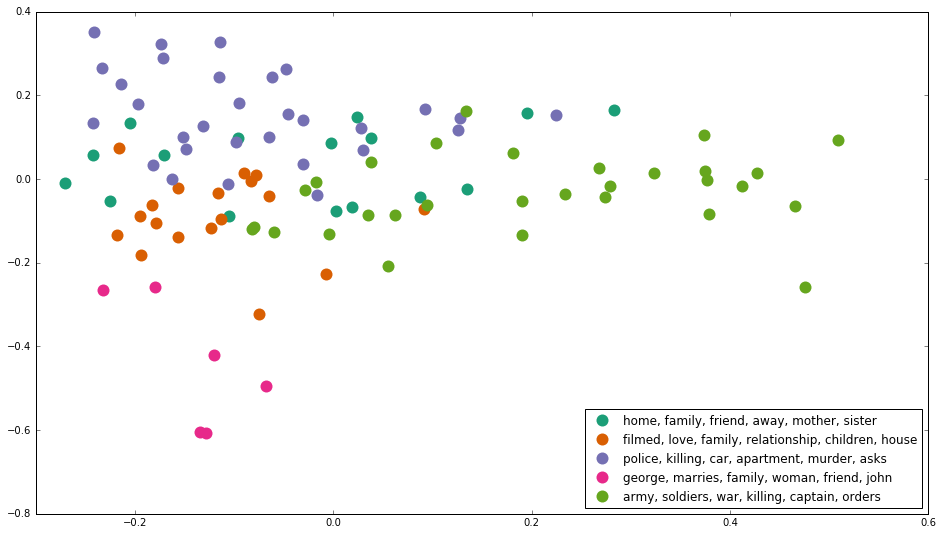

In [55]:
%matplotlib inline

# create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16,9))

# set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
           label=cluster_names[name], color=cluster_colors[name],
           mec='none')

ax.legend(numpoints=1, loc=4)  # show legend with only 1 point, position is right bottom.

plt.show()

In [ ]:
plt.close()

## Part 5: Topic Modeling - Latent Dirichlet Allocation

In [ ]:
terms_dict = {tf_selected_words[x]: x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)

feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [ ]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=1)

- `model.topic_word_` saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
- The shape of `model.topic_word_` is (n_topics, num_of_selected_words)
- `model.doc_topic_` saves the document topic results, i.e. document topic matrix.
- The shape of `model.doc_topic_` is (num_of_documents, n_topics)

In [ ]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    # we select to (n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1]
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [ ]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])

for i in topic_doc_dict:
    print("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print(', '.join(topic_doc_dict[i]))


### Plots

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50)

In [ ]:
from sklearn.cluster import KMeans
est = KMeans(4)
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)